- Load Files

In [1]:
import pandas as pd

data = pd.read_csv('/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv')
sample_submission = pd.read_csv('/kaggle/input/child-mind-institute-detect-sleep-states/sample_submission.csv')

- Fill NaN Values

In [2]:
data.fillna(0, inplace=True)

- Drop timestamp column

In [3]:
data.drop(columns=['timestamp'], inplace=True)

- Capped Outliers

In [4]:
# Define a function to cap outliers based on the interquartile range (IQR)
def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

# Apply the function to the 'step' column
cap_outliers(data, 'step')

- One Hot Encoding

In [5]:
data = pd.get_dummies(data, columns=['event'])
data

,series_id,night,step,event_onset,event_wakeup
0,038441c925bb,1,4992.0,True,False
1,038441c925bb,1,10932.0,False,True
2,038441c925bb,2,20244.0,True,False
3,038441c925bb,2,27492.0,False,True
4,038441c925bb,3,39996.0,True,False
...,...,...,...,...,...
14503,fe90110788d2,33,560604.0,False,True
14504,fe90110788d2,34,574620.0,True,False
14505,fe90110788d2,34,581604.0,False,True
14506,fe90110788d2,35,0.0,True,False


- Label Encoding

In [6]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

data['series_id'] = label_encoder.fit_transform(data['series_id'])

- Setup features and target

In [7]:
features = data[['series_id', 'night', 'step']]
target = data[['event_onset', 'event_wakeup']]

- train-test split with stratification

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=42, stratify=target
)

- Train XGBoost Model

In [9]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import average_precision_score
import xgboost as xgb
import numpy as np

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Initialize the model
model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y_train.values.argmax(axis=1))))

average_precisions = []

for train_index, val_index in kf.split(X_train):
    # Split the data into training and validation sets
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.values[train_index], y_train.values[val_index]

    # Scale the features
    X_train_fold_scaled = scaler.fit_transform(X_train_fold)
    X_val_fold_scaled = scaler.transform(X_val_fold)

    # Train the model
    model.fit(X_train_fold_scaled, y_train_fold.argmax(axis=1))

    # Make predictions on the validation set
    y_val_pred_proba = model.predict_proba(X_val_fold_scaled)

    # Evaluate average precision
    ap = average_precision_score(y_val_fold, y_val_pred_proba, average="macro")
    average_precisions.append(ap)

# Calculate the average precision
average_precision = np.mean(average_precisions)
average_precision

0.8746245663136692

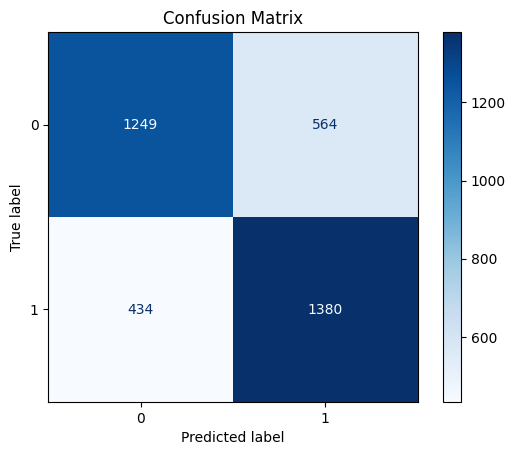

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get true labels and predicted labels for the test set
X_test_scaled = scaler.transform(X_test)
y_test_pred = model.predict(X_test_scaled)

# Calculate confusion matrix
y_test_true = y_test.values.argmax(axis=1)
cm = confusion_matrix(y_test_true, y_test_pred)

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

- The model results classified 1249 as false (class = 0)
- The model results classified 1380 as true (class = 1)

In [11]:
import joblib

# Save the trained model to a .pkl file
joblib.dump(model, 'detect_sleep_onset_wake.pkl')

['detect_sleep_onset_wake.pkl']

In [12]:
# Revert one-hot encoding for the predicted test set
y_pred_original = np.array(["onset" if pred == 0 else "wakeup" for pred in y_test_pred])
y_pred_original

array(['wakeup', 'onset', 'onset', ..., 'onset', 'wakeup', 'wakeup'],
      dtype='<U6')

In [13]:
# Align the predictions with the original series_id
predictions = pd.DataFrame({
    'series_id': label_encoder.inverse_transform(X_test['series_id']),
    'predicted_event': y_pred_original
})

predictions

,series_id,predicted_event
0,ce85771a714c,wakeup
1,dff367373725,onset
2,77ca4db83644,onset
3,1319a1935f48,onset
4,c5d08fc3e040,wakeup
...,...,...
3622,d9e887091a5c,wakeup
3623,6d6b9d22d48a,wakeup
3624,5ffd5e1e81ac,onset
3625,0cd1e3d0ed95,wakeup


- Calculate the percentage of each predicted event

In [15]:
predicted_event_counts = predictions['predicted_event'].value_counts(normalize=True) * 100
predicted_event_counts

predicted_event
wakeup    53.598015
onset     46.401985
Name: proportion, dtype: float64

- Create a pie chart for the percentage of each predicted event

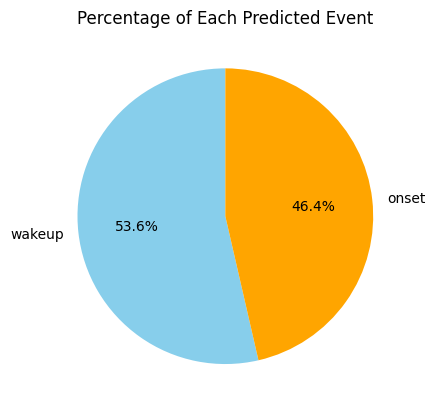

In [16]:
import matplotlib.pyplot as plt

predicted_event_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['skyblue', 'orange'])
plt.title('Percentage of Each Predicted Event')
plt.ylabel('')  # Remove y-axis label for better visualization
plt.show()

- The prediction results showed that sleep onset was detected 46.4% of the time, while wake states were detected 53.6% of the time.